In [1]:
import numpy as np
import pycbc.waveform as pycbc_wf
import bilby
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot as plt
import pycbc

In [2]:
bilby.core.utils.parsec

3.085677581491367e+16

In [3]:
def time_domain_model(time_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
         **waveform_kwargs):
    """ Time Domain Model for the inspiral phase """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 20.0)

    reference_frequency = waveform_kwargs.get('reference_frequency', 50.0)
    

    
    m1 = mass_1 #* bilby.core.utils.solar_mass
    m2 = mass_2 #* bilby.core.utils.solar_mass
    #luminosity_distance = luminosity_distance * 1e6 * bilby.core.utils.parsec
    
    minimum_time = time_array[0]
    maximum_time = time_array[-1]
    
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)


    
    delta_time = time_array[1] - time_array[0]
    
#     time_bounds = ((time_array >= minimum_time) *
#                         (time_array <= maximum_time))
    

    hplus, hcross = pycbc_wf.get_td_waveform( approximant = 'IMRPhenomPv2',#'SpinTaylorT4',
            mass1=mass_1, mass2=mass_2, spin1x=spin_1x,  spin1y=spin_1y, spin1z=spin_1z, 
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z, distance=luminosity_distance, 
            inclination=iota, coa_phase=phase,  delta_t = delta_time,
            f_lower = start_frequency, f_ref=reference_frequency)
            #**waveform_dictionary)

    h_plus = np.zeros_like(time_array, dtype=complex)
    h_cross = np.zeros_like(time_array, dtype=complex)


    if len(hplus.data.data) > len(time_array):

        h_plus = hplus.data.data[:len(h_plus)]
        h_cross = hcross.data.data[:len(h_cross)]

        
    else:
        h_plus[-len(hplus.data.data):] = hplus.data.data
        h_cross[-len(hcross.data.data):] = hcross.data.data

#     h_plus *= time_bounds
#     h_cross *= time_bounds
    
    tindex = np.argmax(h_plus)
    zeros_length = len(h_plus[tindex:])
    
    h_plus = h_plus[:tindex]
    h_cross = h_cross[:tindex]
    
    h_plus = np.concatenate((np.zeros(zeros_length), h_plus))
    h_cross = np.concatenate((np.zeros(zeros_length), h_cross))
    



    return dict(plus=h_plus, cross=h_cross)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


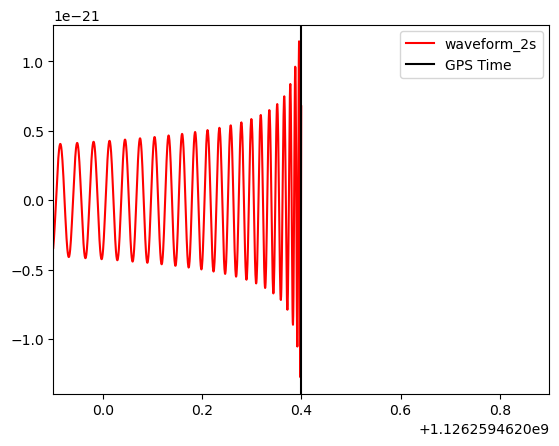

In [4]:
tg = 1126259462.4
t = np.arange(tg-4,tg,1/2048)

model = time_domain_model(t, 20, 30, 400, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

#t6 = np.arange(tg-4,tg,1/2048)

# model6 = time_domain_model(t6, 20, 30, 400, 0.3, 0.2,
#          a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']



plt.plot(t,model,color='r',label='waveform_2s')
#plt.plot(t6,model6,color='b',label='waveform_4s')

plt.xlim([tg-0.5, tg+0.5])

plt.axvline(tg,color='k',label='GPS Time')
plt.legend()
plt.show()

In [30]:
tarr = np.arange(-4,0,1/2048)
tdwf = time_domain_model(tarr, 50, 30, 400, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

In [27]:
len(tdwf), len(tarr)

(8192, 8192)

In [5]:
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=1000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

In [6]:
duration = 4
sampling_frequency = 4096
outdir = "pe_inspiral_injection_7parameter_500nl"
label = "time_domain_source_model"

In [7]:
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_model,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    start_time=injection_parameters["geocent_time"] - duration, waveform_arguments={
        "reference_frequency": 50,
    }

)


23:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.time_domain_model
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [8]:
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])

In [9]:
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - duration,
)

In [10]:
ifos.inject_signal(
    waveform_generator=waveform, parameters=injection_parameters, raise_error=False
)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
23:16 bilby INFO    : Injected signal in H1:
23:16 bilby INFO    :   optimal SNR = 21.08
23:16 bilby INFO    :   matched filter SNR = 21.81-0.18j
23:16 bilby INFO    :   mass_1 = 36.0
23:16 bilby INFO    :   mass_2 = 29.0
23:16 bilby INFO    :   a_1 = 0.4
23:16 bilby INFO    :   a_2 = 0.3
23:16 bilby INFO    :   tilt_1 = 0.5
23:16 bilby INFO    :   tilt_2 = 1.0
23:16 bilby INFO    :   phi_12 = 1.7
23:16 bilby INFO    :   phi_jl = 0.3
23:16 bilby INFO    :   luminosity_distance = 1000.0
23:16 bilby INFO    :   theta_jn = 0.4
23:16 bilby INFO    :   psi = 2.659
23:16 bilby INFO    :   phase = 1.3
23:16 bilby INFO    :   geocent_time = 1126259642.413
23:16 bilby INFO    :   ra = 1.375
23:16 bilby INFO    :   dec = -1.2108
23:16 bilby INFO    : 

[{'plus': array([-1.70914182e-25+0.00000000e+00j, -1.70999813e-25-1.26769801e-27j,
         -1.71248331e-25-2.48274780e-27j, ...,
         -8.31224853e-26+2.51479438e-29j, -8.31244443e-26+1.23581907e-29j,
         -8.31251209e-26+0.00000000e+00j]),
  'cross': array([-5.64172671e-25+0.00000000e+00j, -5.64222032e-25-4.56273844e-30j,
         -5.64364402e-25+2.38614605e-29j, ...,
          1.93947657e-26+1.25145107e-29j,  1.93986024e-26+6.68003652e-30j,
          1.93999274e-26+0.00000000e+00j])},
 {'plus': array([-1.70914182e-25+0.00000000e+00j, -1.70999813e-25-1.26769801e-27j,
         -1.71248331e-25-2.48274780e-27j, ...,
         -8.31224853e-26+2.51479438e-29j, -8.31244443e-26+1.23581907e-29j,
         -8.31251209e-26+0.00000000e+00j]),
  'cross': array([-5.64172671e-25+0.00000000e+00j, -5.64222032e-25-4.56273844e-30j,
         -5.64364402e-25+2.38614605e-29j, ...,
          1.93947657e-26+1.25145107e-29j,  1.93986024e-26+6.68003652e-30j,
          1.93999274e-26+0.00000000e+00j])}]

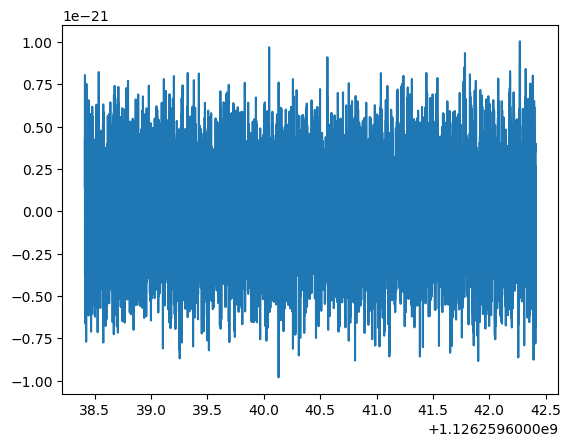

In [11]:
plt.plot(ifos[0].time_array,ifos[0].time_domain_strain)

In [12]:
priors = bilby.gw.prior.BBHPriorDict()

23:16 bilby INFO    : No prior given, using default BBH priors in /cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [13]:
priors['luminosity_distance'].maximum = 2000

In [14]:

for key in [
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
]:
    priors[key] = injection_parameters[key]

In [15]:
priors

{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': UniformSourceFrame(minimum=100.0, maximum=2000, cosmology=FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None),
 'dec': -1.2108,
 'ra': 1.375,
 'theta_jn': Sine(minimum=0, maximum=3.141592653589793, name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, boundary=None),
 'psi': 2.659,
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=No

In [16]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifos, waveform)

In [17]:
result = bilby.core.sampler.run_sampler(
    likelihood,
    priors,
    sampler="dynesty",
    
    
    nlive = 300,
    #npool=8,
    nact=5,
    injection_parameters=injection_parameters,
    check_point_delta_t=200,
    check_point_plot=True,
    outdir=outdir,
    label=label,
)


23:16 bilby INFO    : Running for label 'time_domain_source_model', output will be saved to 'pe_inspiral_injection_7parameter_500nl'
23:16 bilby INFO    : Using lal version 7.1.7
23:16 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
23:16 bilby INFO    : Using lalsimulation version 3.1.2
23:16 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
23:16 bilby INFO    : Search parameters:
23:16 bilby INFO    :   mass_ratio = Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
23:16 bilby INFO    :   chirp_mass = Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, bound

0it [00:00, ?it/s]

23:16 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 300, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 180, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fa684a84430>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
23:16 bilby INFO    : Checkpoint every check_point_delta_t = 200s
23:16 bilby INFO    : Using dynesty version 1.0.1
23:16 bilby INFO    : Using the bil

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
23:27 bilby INFO    : Written checkpoint file pe_inspiral_injection_7parameter_500nl/time_domain_source_model_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: Co

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
23:52 bilby INFO    : Written checkpoint file pe_inspiral_injection_7parameter_500nl/time_domain_source_model_resume.pickle
23:52 bilby WARNING : singular matrix
23:52 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.o

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
00:09 bilby INFO    : Written checkpoint file pe_inspiral_injection_7parameter_500nl/time_domain_source_model_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: Co

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
00:1

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
00:23 bilby INFO    : Written checkpoint file pe_inspiral_injection_7parameter_500nl/time_domain_source_model_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: Co

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
00:34 bilby INFO    : Written checkpoint file pe_inspiral_injection_7parameter_500nl/time_domain_source_model_resume.pickle
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: Co

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
01:0

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
02:0

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
02:1

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
/cvm

02:34 bilby INFO    : Sampling time: 3:17:37.060505
02:34 bilby INFO    : Summary of results:
nsamples: 6212
ln_noise_evidence: -16604.142
ln_evidence: -16246.367 +/-  0.312
ln_bayes_factor: 357.775 +/-  0.312



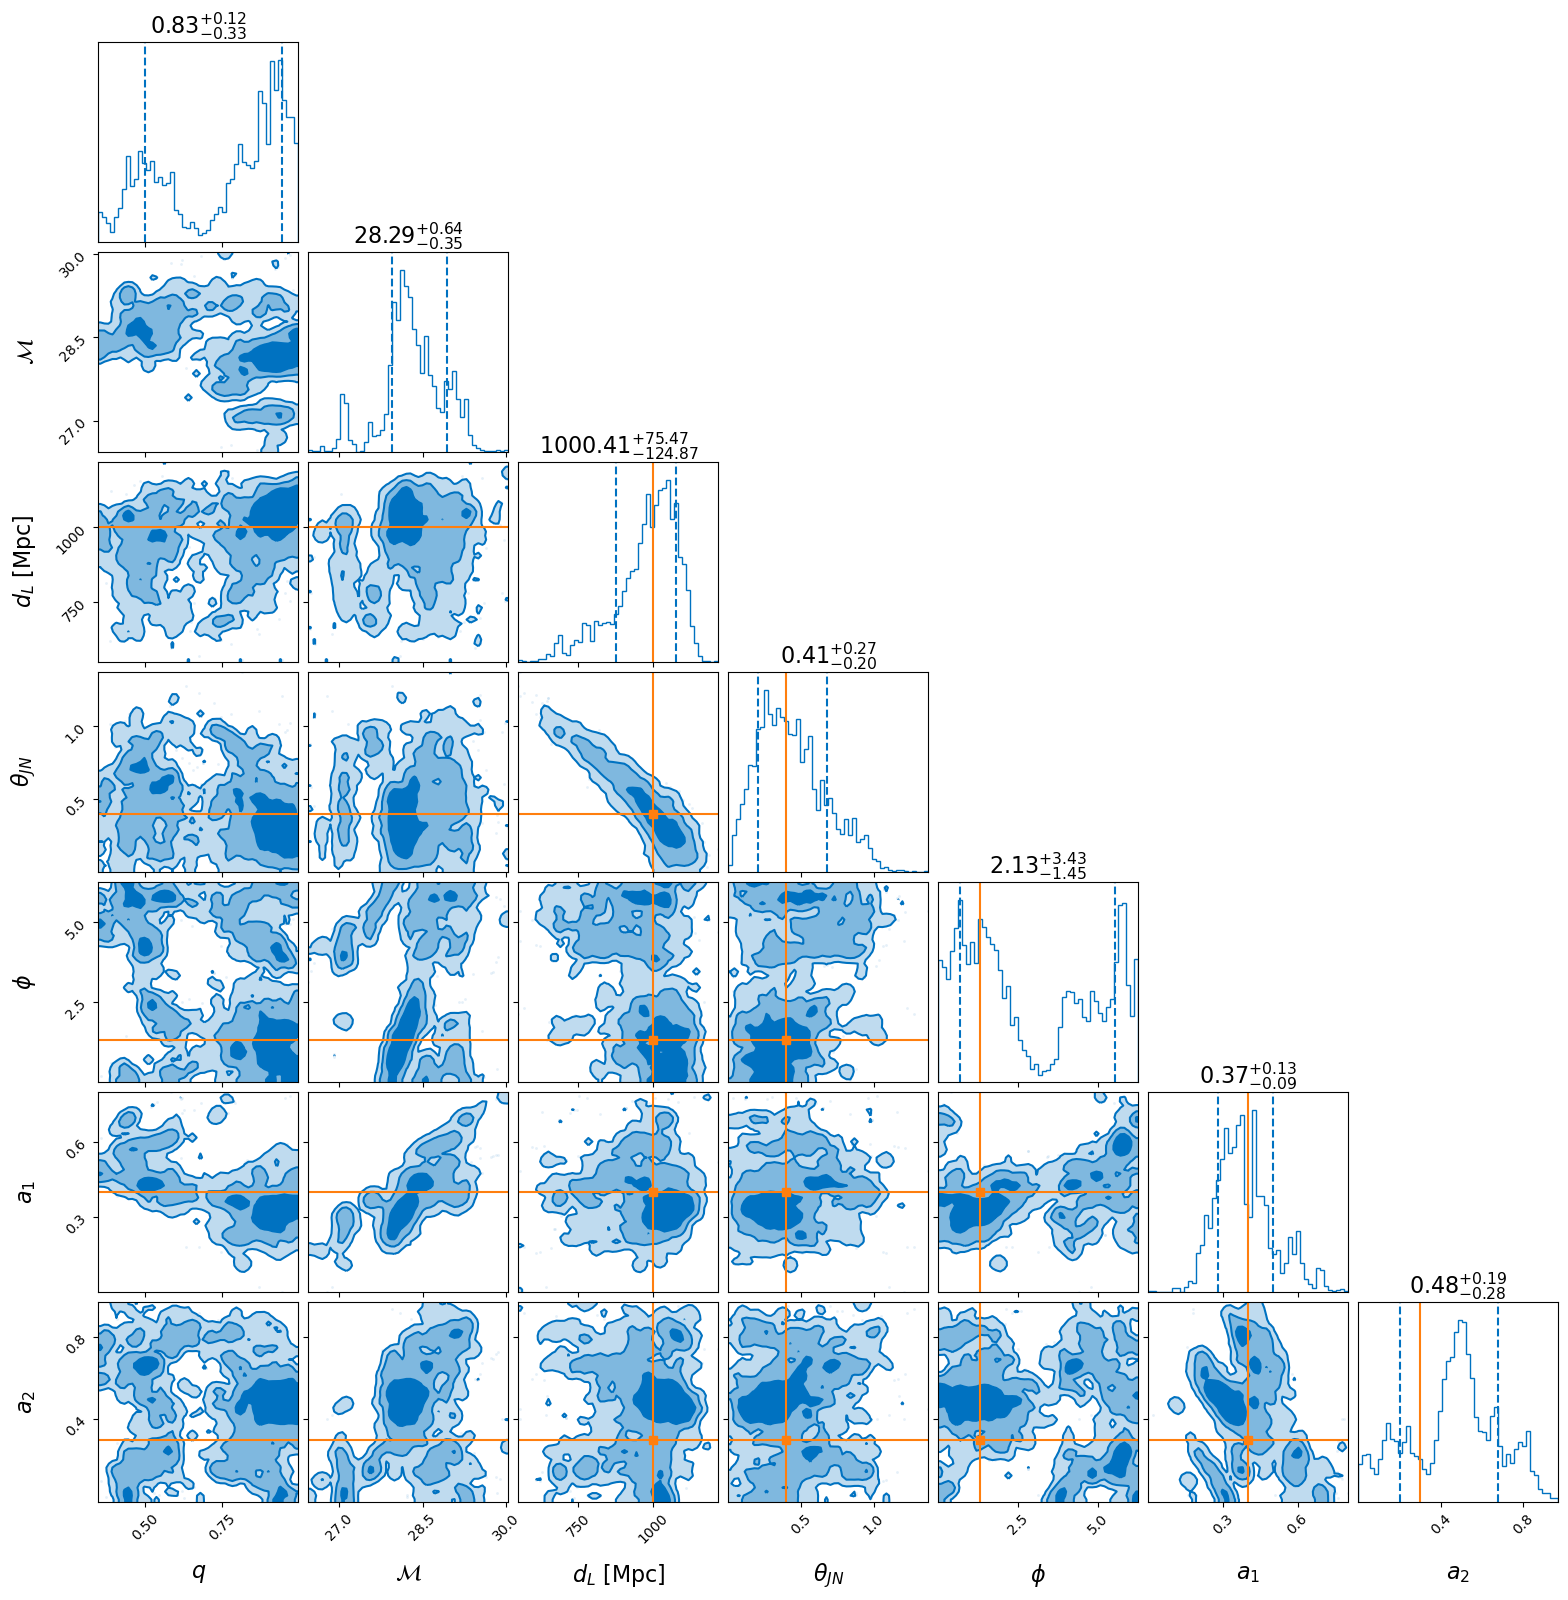

In [18]:
result.plot_corner()

In [118]:
res = bilby.core.result.Result(result)

In [125]:
mass_rat = res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir_inj/time_domain_source_model_result.json').posterior['mass_ratio']
dist = res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir_inj/time_domain_source_model_result.json').posterior['luminosity_distance']

In [131]:
res.from_json('/home1/akash.mishra/Area_law/Notebooks/outdir_inj_1/time_domain_source_model_result.json').posterior

,mass_ratio,chirp_mass,luminosity_distance,theta_jn,dec,ra,psi,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,geocent_time,log_likelihood,log_prior
0,0.803889,28.148661,369.592033,0.491639,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2249.939184,-15.778385
1,0.802802,28.075178,238.758755,1.230865,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2251.027539,-15.836205
2,0.816012,28.073975,377.324090,0.545071,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2251.682149,-15.650289
3,0.808719,28.027159,346.426047,0.668608,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2252.453889,-15.613996
4,0.816982,28.047250,369.671856,0.631669,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2252.734535,-15.554201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0.802640,28.100407,426.212817,0.203664,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2261.008859,-16.392233
1306,0.802640,28.100407,426.212817,0.203664,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2261.008859,-16.392233
1307,0.802640,28.100407,426.212817,0.203664,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2261.008859,-16.392233
1308,0.803307,28.097917,424.277418,0.249177,-1.2108,1.375,2.659,1.3,0.4,0.3,0.5,1.0,1.7,0.3,1.126260e+09,2261.022902,-16.201363


(array([  1.,   0.,   0.,   2.,   9.,  10.,   2.,  11.,  13.,  32.,  51.,
         23.,  24.,  41.,  34.,  36.,  57.,  59.,  61., 109.,  84.,  68.,
         91., 110., 127., 111., 103.,  33.,   6.,   2.]),
 array([238.75875497, 246.0518172 , 253.34487944, 260.63794167,
        267.93100391, 275.22406614, 282.51712837, 289.81019061,
        297.10325284, 304.39631508, 311.68937731, 318.98243955,
        326.27550178, 333.56856401, 340.86162625, 348.15468848,
        355.44775072, 362.74081295, 370.03387518, 377.32693742,
        384.61999965, 391.91306189, 399.20612412, 406.49918635,
        413.79224859, 421.08531082, 428.37837306, 435.67143529,
        442.96449753, 450.25755976, 457.55062199]),
 <BarContainer object of 30 artists>)

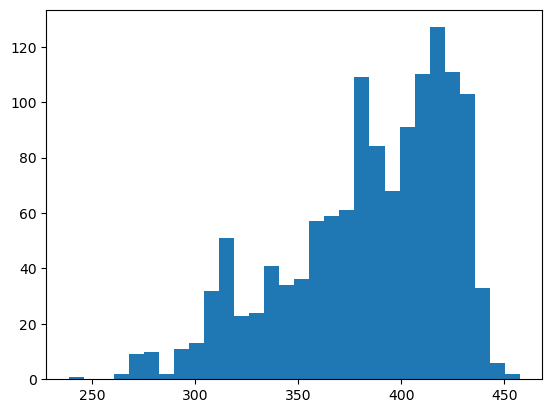

In [128]:
plt.hist(dist, bins = 30)

1783.9061283691276

In [104]:
def ppe_model(frequency_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
         **waveform_kwargs):
    """ Inspiral Phase Modelling """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 20.0)
    maximum_frequency = waveform_kwargs.get('maximum_frequency', frequency_array[-1])
    reference_frequency = waveform_kwargs.get('reference_frequency', 50.0)
    waveform_dictionary = dict(spin_order=-1, tidal_order=-1,
        phase_order=-1, amplitude_order=0)
    
    m1 = mass_1 * bilby.core.utils.solar_mass
    m2 = mass_2 * bilby.core.utils.solar_mass
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)

    longitude_ascending_nodes = 0.0
    mean_per_ano = 0.0
    
    delta_frequency = frequency_array[1] - frequency_array[0]
    frequency_bounds = ((frequency_array >= minimum_frequency) *
                        (frequency_array <= maximum_frequency))
    

    hplus, hcross = pycbc_wf.get_fd_waveform( approximant = 'IMRPhenomPv2',
            mass1=mass_1, mass2=mass_2, spin1x=spin_1x,  spin1y=spin_1y, spin1z=spin_1z, 
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z, distance=luminosity_distance, 
            inclination=iota, coa_phase=phase, long_asc_nodes=longitude_ascending_nodes, 
            mean_per_ano=mean_per_ano, delta_f = delta_frequency,
            f_lower = start_frequency, f_final=maximum_frequency, f_ref=reference_frequency,
            **waveform_dictionary)

    
    h_plus = np.zeros_like(frequency_array, dtype=complex)
    h_cross = np.zeros_like(frequency_array, dtype=complex)

    if len(hplus.data.data) > len(frequency_array):
        logger.debug("Pycbc PPE waveform longer than bilby's `frequency_array`" +
                     "({} vs {}), ".format(len(hplus.data.data), len(frequency_array)) +
                     "probably because padded with zeros up to the next power of two length." +
                     " Truncating pycbc ppe array.")
        h_plus = hplus.data.data[:len(h_plus)]
        h_cross = hcross.data.data[:len(h_cross)]
    else:
        h_plus[:len(hplus.data.data)] = hplus.data.data
        h_cross[:len(hcross.data.data)] = hcross.data.data

    h_plus *= frequency_bounds
    h_cross *= frequency_bounds
    
    #print(type(hplus.start_time.gpsSeconds + hplus.start_time.gpsNanoSeconds * 1e-9))
    #print(hplus.delta_f)
#     dt = 1 / hplus.delta_f + hplus.start_time.gpsSeconds + hplus.start_time.gpsNanoSeconds * 1e-9
#     time_shift = np.exp(-1j * 2 * np.pi * dt * frequency_array[frequency_bounds])
#     h_plus[frequency_bounds] *= time_shift
#     h_cross[frequency_bounds] *= time_shift


    return dict(plus=h_plus, cross=h_cross)

In [99]:
frequency_array = np.linspace(20, 512, 300)

fd = ppe_model(frequency_array, 35, 32, 400, 0, 0,
         0.3, 0.2, 0.0, 0.5, 0.0, 0.0)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


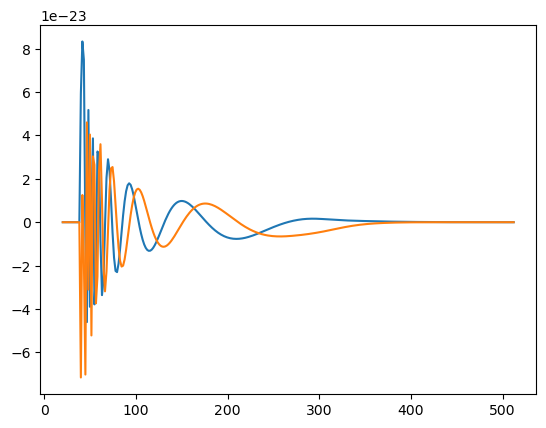

In [103]:
plt.plot(frequency_array, fd['plus'])
plt.plot(frequency_array, fd['cross'])

In [105]:
frequency_array = np.linspace(20, 512, 300)

fd1 = ppe_model(frequency_array, 35, 32, 400, 0, 0,
         0.3, 0.2, 0.0, 0.5, 0.0, 0.0)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


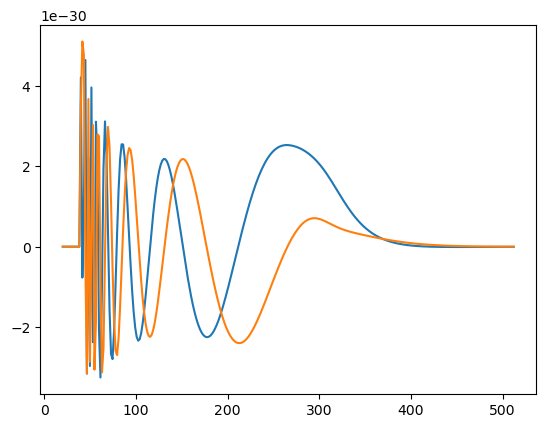

In [108]:
plt.plot(frequency_array, fd1['plus']-fd['plus'])
plt.plot(frequency_array, fd1['cross']-fd['cross'])

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


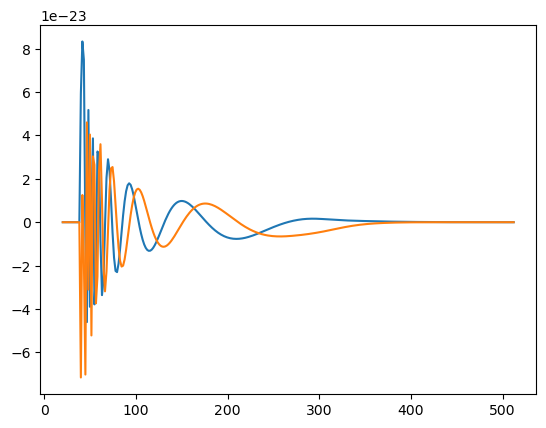

In [109]:
plt.plot(frequency_array, fd1['plus'])
plt.plot(frequency_array, fd1['cross'])

In [132]:
bilby.core.sampler.run_sampler??